In [1]:
from zipfile import ZipFile
from IPython.display import FileLink, FileLinks
import os
from pprint import pprint

import time
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import random
import statistics as stats
import numpy as np
from scipy.stats import mstats
import itertools
import scipy.stats

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.api import OLS

# Loading and Cleaning Mood Data

First we'll take a look at `Mood`. Later we'll look at `Mood 1` and `Mood 2`.

In [83]:
path = '/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/EMA/response/Mood/mood.zip'

zip_file = ZipFile(path)

In [84]:
# Extract all file names from zip_file with a list comprhension
# and if-filtering using .startswith() and .endswith()
filenames = [
    text_file.filename
    for text_file
    in zip_file.infolist()
    if (text_file.filename.endswith('.json') &
        ~text_file.filename.startswith('__')
       )
]

In [85]:
# Creating dictionary with each file in the zip file loaded into a
# Pandas DataFrame as a value. Keys are the file names
                     
ema_dfs = {
    filename: pd.read_json(zip_file.open(filename))
    for filename
    in filenames
}

Add a column to each dataframe that contains the filename of the file the df comes from so that when we concatenate the dfs into a single df we can see which file each row came from and therefore also be able to see what student id the data is associated with. We'll using string methods to edit this column so that it's identical to the uid column in our other dfs.

In [86]:
# Adding filename column to each df named 'uid'
for df_key in ema_dfs:
    df = ema_dfs[df_key]
    df['uid'] = df_key

# Concatening all dfs
ema = pd.concat(
    [ema_dfs[df] for df in ema_dfs],
    # Defining 'sort' as False to prevent current version
    # of pandas from sorting due to non-concatenation axis nonalignment
    sort=True
)

In [87]:
# Using regex to extract uid num with
# pandas string expressions
pat = '(\d{2})'
ema.uid = ema.uid.str.extract(
    pat=pat,
    flags=0,
    expand=True
    # Rendering column type as integer
).astype(int)

I'm not sure what values are in the index column based on the EMA dictionary. I'm just going to drop this column provisionally by resetting the index and setting drop to true.

In [88]:
ema = ema.reset_index(drop=True)

We also need to split location up into longitude and latitude. We'll just do with with split from pandas string expressions.

In [8]:
try:
    ema['latitude'] = ema.location.str.split(',').str.get(0)
    ema['longitude'] = ema.location.str.split(',').str.get(1)
    ema = ema.drop(columns=['location'])
except:
    pass

In [9]:
# Converting 'Unknown' to np.nan
for col in ema:
    ema.loc[ema[col]=='Unknown', col] = np.nan

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


### Exploring Mood 1 and Mood 2

Now we'll load up `Mood 1` and `Mood 2` data and merge the dataframes.

In [10]:
path = '/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/EMA/response/Mood 1/mood_1.zip'

zip_file_1 = ZipFile(path)

path = '/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/EMA/response/Mood 2/mood_2.zip'

zip_file_2 = ZipFile(path)

In [11]:
# Extract all file names from zip_file with a list comprhension
# and if-filtering using .startswith() and .endswith()
mood_1_filenames = [
    text_file.filename
    for text_file
    in zip_file_1.infolist()
    if (text_file.filename.endswith('.json') &
        ~text_file.filename.startswith('__')
       )
]

mood_2_filenames = [
    text_file.filename
    for text_file
    in zip_file_2.infolist()
    if (text_file.filename.endswith('.json') &
        ~text_file.filename.startswith('__')
       )
]

In [12]:
# Going through the same process as with the mood dfs,
# and simplifying by creating function and appling to
# Mood 1 and Mood 2

def concat_dfs(zip_file, filenames):
    
    mood_dfs = {
        filename: pd.read_json(zip_file.open(filename))
        for filename
        in filenames
    }

    # Adding filename column to each df named 'uid'
    for df_key in mood_dfs:
        df = mood_dfs[df_key]
        df['uid'] = df_key

    # Concatening all dfs
    mood_df = pd.concat(
        [mood_dfs[df] for df in mood_dfs],
        # Defining 'sort' as False to prevent current version
        # of pandas from sorting due to non-concatenation axis nonalignment
        sort=True,
        # Setting ignore_index to true makes sure the new dataframe
        # has regular rather than repeating or redundant index values
        ignore_index=True
    )
    
    pat = '(\d{2})'
    mood_df.uid = mood_df.uid.str.extract(
        pat=pat,
        flags=0,
        expand=True
        # Rendering column type as integer
        ).astype(int)
    
    # Splitting location into latlon
    mood_df['latitude'] = mood_df.location.str.split(',').str.get(0)
    mood_df['longitude'] = mood_df.location.str.split(',').str.get(1)
    
    # Converting 'Unknown' and 'null' to np.nan
    for col in mood_df:
        mood_df.loc[mood_df[col]=='Unknown', col] = np.nan
        mood_df.loc[mood_df[col]=='null', col] = np.nan
    
    return mood_df

# Calling concat_dfs on Mood 1 and Mood 2
mood1 = concat_dfs(zip_file_1, mood_1_filenames)
mood2 = concat_dfs(zip_file_2, mood_2_filenames)

# Dropping superfluous 'location' column. This needs to
# be done outside the function between the column is needed
# when dealing with the stress dataframe below.
mood1 = mood1.drop(columns=['location'])
mood2 = mood2.drop(columns=['location'])

In [13]:
# Drop empty null column
mood2 = mood2.drop(columns=['null'])

## Checking concatenated dfs

First let's see how well the dataframes match up when we merge them on `uid` and `resp_time`.

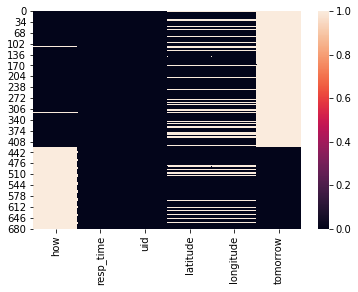

In [14]:
# Testing merge of Mood 1 and Mood 2
test_1 = mood2.merge(
    mood1,
    how='outer',
    on=['uid',
        'resp_time',
        'latitude',
        'longitude']
)

sns.heatmap(test_1.isnull())

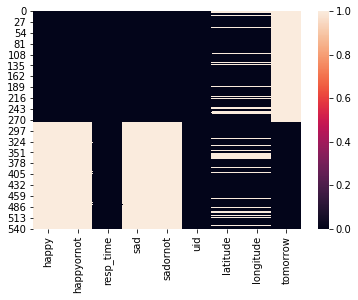

In [15]:
# Testing merge of Mood (ema) and Mood 1
test_2 = ema.merge(
    mood1,
    how='outer',
    on=['uid',
        'resp_time',
        'latitude',
        'longitude']
)

sns.heatmap(test_2.isnull())

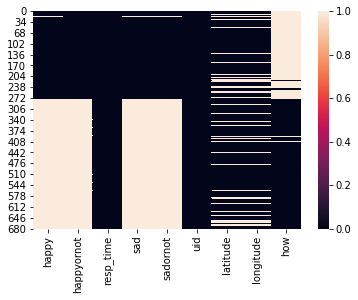

In [16]:
# Testing merge of Mood (ema) and Mood 2
test_3 = ema.merge(
    mood2,
    how='outer',
    on=['uid',
        'resp_time',
        'latitude',
        'longitude']
)

sns.heatmap(test_3.isnull())

From this we can surmise there's not a really meaningful way to combine these dataframes. `Mood` (ema) contains the most granular data, so we'll continue with that dataframe.

## Cleaning happy/sad features

There appears to be a problem with the survey or the way it's loaded into the json where students who report not being happy at all ('2' in `happyornot`) still have to answer the question in `happy` about how happy they feel, where the least happy option is 'a little bit (happy)'. As we can see below, 100% of the students who reply '2' (not at all happy) to `happyornot` reply with the least happy option to `happy`, indicating that they were forced to choose a 'more happy' answer to the question than is their actual emotional state.

In [17]:
# Grabbing values counts for student responses to 'happy'
# among students who replied no to 'happyornot'
ema.loc[ema.happyornot==2, 'happy'].value_counts()

1.0    42
Name: happy, dtype: int64

So first we need to be aware that there may be similar problems in other areas of the EMA data. Second, to handle this issue, we just need to create a new entry for `happy` (and add this to the dictionary json that came with the dartmouth data). This entry will be coded as `0` and will represent `not at all happy`.

In [18]:
# Defining not at all happy observations as not at all happy
# in the happy columns
ema.loc[ema.happyornot==2, 'happy'] = 0

# Displaying new value counts
ema.happy.value_counts()

1.0    82
2.0    80
3.0    57
0.0    42
4.0    15
Name: happy, dtype: int64

In [19]:
# Displaying value counts for the sad variable among
# observations that claimed no degree of sadness
ema.loc[ema.sadornot==2, 'sad'].value_counts()

1.0    65
Name: sad, dtype: int64

We're seeing the same thing in the sad columns, so we'll apply the same transformation and edit the dictionary.

In [20]:
# Defining not at all sad observations as not at all sad
# in the sad columns
ema.loc[ema.sadornot==2, 'sad'] = 0

# Displaying new value counts
ema.sad.value_counts()

1.0    153
0.0     65
2.0     26
3.0     19
4.0     13
Name: sad, dtype: int64

In [21]:
# Defining not at all sad observations as not at all sad
# in the sad columns
ema.loc[ema.sadornot==2, 'sad'] = 0

# Displaying new value counts
ema.happy.value_counts()

1.0    82
2.0    80
3.0    57
0.0    42
4.0    15
Name: happy, dtype: int64

In doing this we also discovered the `happyornot` values need to be cleaned more because values that both appear to be 1 or 2 are getting treated as different values, and there may be 'null' values that aren't `np.nan`.

In [22]:
ema.happyornot.value_counts()

1       224
2        42
1         5
null      4
2         2
Name: happyornot, dtype: int64

In [23]:
# Checking type for 'null' vals
[type(val) for val in ema.loc[ema.happyornot=='null', 'happyornot']]

[str, str, str, str]

In [24]:
# Converting 'null' valls in whole df to np.nan
# Converting 'Unknown' to np.nan
for col in ema:
    ema.loc[ema[col]=='null', col] = np.nan

In [25]:
# Generating value counts again
ema.happyornot.value_counts()

1    224
2     42
1      5
2      2
Name: happyornot, dtype: int64

In [26]:
# Lets see if this issue is fixed by converting all values to int
ema.loc[
    ema.happyornot.notnull(),
    'happyornot'
] = ema.loc[
    ema.happyornot.notnull(),
    'happyornot'
].astype(int)

ema.happyornot.value_counts()

1    229
2     44
Name: happyornot, dtype: int64

In [27]:
# Performing same operation on 'sadornot'
print(ema.sadornot.value_counts())

ema.loc[
    ema.sadornot.notnull(),
    'sadornot'
] = ema.loc[
    ema.sadornot.notnull(),
    'sadornot'
].astype(int)

ema.sadornot.value_counts()

1    96
2    65
2    60
1    46
Name: sadornot, dtype: int64


1    142
2    125
Name: sadornot, dtype: int64

# Exploring features

What's really noteable just from our value counts is that a really high percentage of observations are both sad and happy to some degree all the time. Let's see if we can calculate this percentage and then generate a stacked bar graph that indicates the overlap for the more precise EMA mood data.

In [28]:
print('{:.0%} of observations report some degree of sadness'
      .format(len(ema[ema.sadornot==1]) / len(ema))
     )

print('{:.0%} of observations report some degree of happiness'
      .format(len(ema[ema.happyornot==1]) / len(ema))
     )

print('{:.0%} of observations report no degree of sadness'
      .format(len(ema[ema.sadornot==2]) / len(ema))
     )

print('{:.0%} of observations report no degree of happiness'
      .format(len(ema[ema.happyornot==2]) / len(ema))
     )

51% of observations report some degree of sadness
83% of observations report some degree of happiness
45% of observations report no degree of sadness
16% of observations report no degree of happiness


So at minimum, 34% of observations are reporting some degree of happiness and sadness at the same time. (Only 49% of observations report no degree of sadness, so at least 34% of the 83% that report some degree of happiness must also report some degree of sadness.)

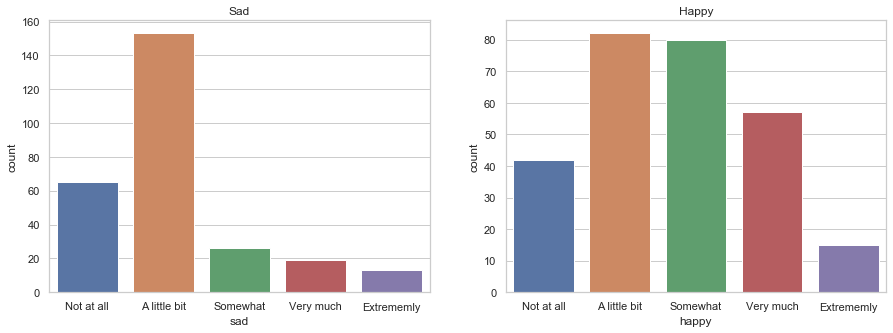

In [29]:
sns.set(style='whitegrid')

plt.figure(figsize=(15,5))
plt.subplot(121)
cplot = sns.countplot(ema.sad)
cplot.set_xticklabels(
    ['Not at all',
     'A little bit',
     'Somewhat',
     'Very much',
     'Extrememly']
)
plt.title('Sad')

plt.subplot(122)
cplot = sns.countplot(ema.happy)
cplot.set_xticklabels(
    ['Not at all',
     'A little bit',
     'Somewhat',
     'Very much',
     'Extrememly']
)
plt.title('Happy')
plt.show()

Here's how our observations spread across a 24 hr period.

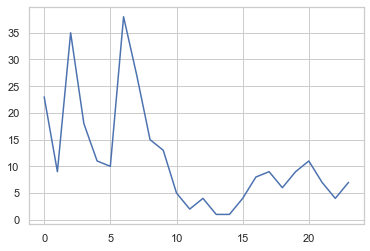

In [30]:
hrs = list(range(24))
hr_counts = [len(ema[ema.resp_time.dt.hour==hr])
             for hr
             in hrs]

lplot = sns.lineplot(
    x=hrs,
    y=hr_counts
)

Now we'll try to visualize happy and sad counts per hour. 

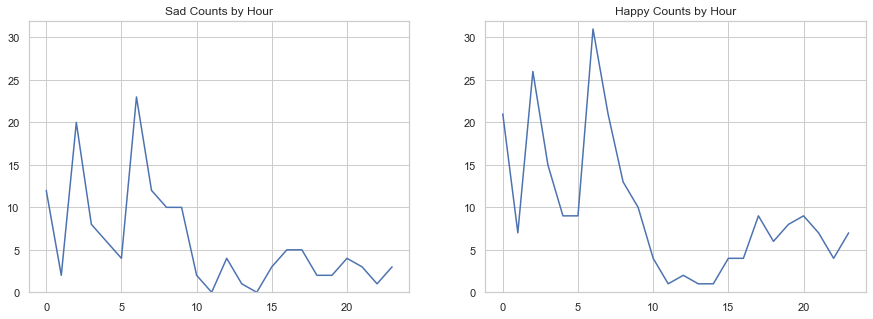

In [31]:
hrs = [hour for hour in ema.resp_time.dt.hour.unique()]
hrs.sort()

sad_counts = [
    len(ema[(ema.sadornot==1) &
            (ema.resp_time.dt.hour==hr)]
             )
    for hr
    in hrs]


hpy_counts = [
    len(ema[(ema.happyornot==1) &
            (ema.resp_time.dt.hour==hr)]
             )
    for hr
    in hrs]

plt.figure(figsize=(15,5))
plt.subplot(121)
lplot = sns.lineplot(
    x=hrs,
    y=sad_counts
)
plt.title('Sad Counts by Hour')
plt.ylim([0,32])
plt.subplot(122)
lplot = sns.lineplot(
    x=hrs,
    y=hpy_counts
)
plt.title('Happy Counts by Hour')
plt.ylim([0,32])
plt.show()

Now we'll do the same for days of the week.

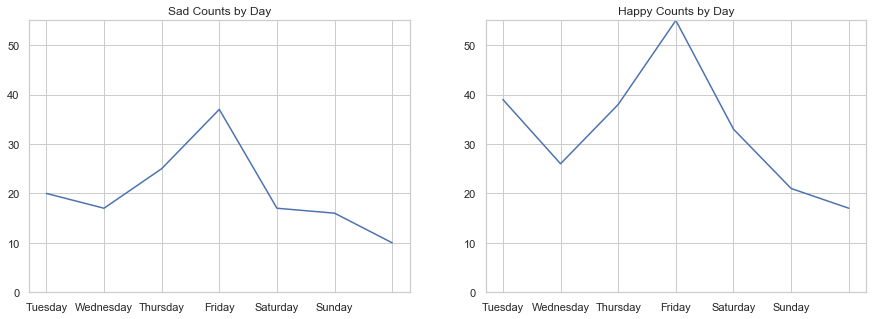

In [32]:
wkds = [wkd for wkd in ema.resp_time.dt.weekday.unique()]
wkds.sort()

sad_counts = [
    len(ema[(ema.sadornot==1) &
            (ema.resp_time.dt.weekday==wkd)]
             )
    for wkd
    in wkds]


hpy_counts = [
    len(ema[(ema.happyornot==1) &
            (ema.resp_time.dt.weekday==wkd)]
             )
    for wkd
    in wkds]

plt.figure(figsize=(15,5))
plt.subplot(121)
lplot = sns.lineplot(
    x=wkds,
    y=sad_counts
)
plt.title('Sad Counts by Day')
plt.ylim([0,55])
lplot.set_xticklabels(
    ['Monday', 'Tuesday', 'Wednesday',
     'Thursday', 'Friday',
     'Saturday', 'Sunday']
)

plt.subplot(122)
lplot = sns.lineplot(
    x=wkds,
    y=hpy_counts
)
plt.title('Happy Counts by Day')
plt.ylim([0,55])
lplot.set_xticklabels(
    ['Monday', 'Tuesday', 'Wednesday',
     'Thursday', 'Friday',
     'Saturday', 'Sunday']
)
plt.show()

Text(0.5, 1.0, 'Diff Counts by Hour')

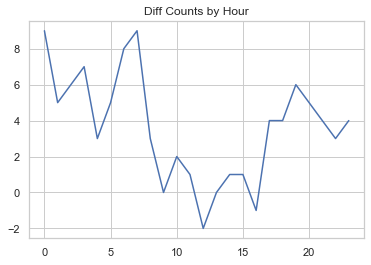

In [33]:
ratio_counts = [
    (len(ema[(ema.happyornot==1) &
            (ema.resp_time.dt.hour==hr)]
             ) -
    len(ema[(ema.sadornot==1) &
            (ema.resp_time.dt.hour==hr)]
             ))
    for hr
    in hrs
]

lplot = sns.lineplot(
    x=hrs,
    y=ratio_counts
)
plt.title('Diff Counts by Hour')

Text(0.5, 1.0, 'Diff Counts by Weekday')

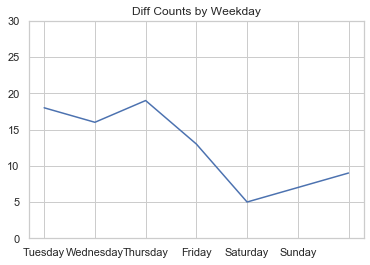

In [34]:
wkds = ema.resp_time.dt.weekday.unique()
wkds.sort()

counts = [
    (len(ema[(ema.happyornot==1) &
            (ema.resp_time.dt.weekday==wkd)]
             ) -
    len(ema[(ema.sadornot==1) &
            (ema.resp_time.dt.weekday==wkd)]
             ))
    for wkd
    in ema.resp_time.dt.weekday.unique()
]

lplot = sns.lineplot(
    x=wkds,
    y=counts
)
lplot.set_xticklabels(
    ['Monday', 'Tuesday', 'Wednesday',
     'Thursday', 'Friday',
     'Saturday', 'Sunday']
)
plt.ylim(0,30)
plt.title('Diff Counts by Weekday')

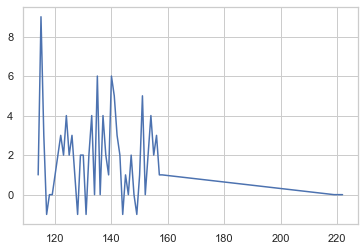

In [35]:
days = [day for day in ema.resp_time.dt.dayofyear.unique()]
days.sort()

counts = [
    (len(ema[(ema.happyornot==1) &
            (ema.resp_time.dt.dayofyear==day)]
             ) -
    len(ema[(ema.sadornot==1) &
            (ema.resp_time.dt.dayofyear==day)]
             ))
    for day
    in days
]

lplot = sns.lineplot(
    x=days,
    y=counts
)

Looks like there are some outliers, `219` and `222`. Let's check out those datetimes.

In [36]:
ema.loc[
    ema.resp_time.dt.dayofyear.isin([219, 222]),
    'resp_time']

49   2013-08-07 01:47:19
50   2013-08-10 03:44:09
Name: resp_time, dtype: datetime64[ns]

In [37]:
# Before dropping, lets display most recent datetime
# before outliers to confirm thats what they are
max(ema.loc[
    ~ema.resp_time.dt.dayofyear.isin([219, 222]),
    'resp_time']
   )

Timestamp('2013-06-07 23:42:36')

In [38]:
ema = ema.loc[
    ~ema.resp_time.dt.dayofyear.isin([219, 222]),
    :]

Now let's generate that lineplot again.

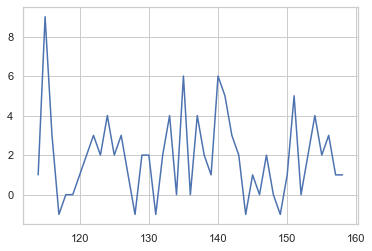

In [39]:
days = [day for day in ema.resp_time.dt.dayofyear.unique()]
days.sort()

counts = [
    (len(ema[(ema.happyornot==1) &
            (ema.resp_time.dt.dayofyear==day)]
             ) -
    len(ema[(ema.sadornot==1) &
            (ema.resp_time.dt.dayofyear==day)]
             ))
    for day
    in days
]

lplot = sns.lineplot(
    x=days,
    y=counts
)

Now let's generate a slight more informative plot by combining the data from the `happy` and `sad` questions that are a little more specific. To do this we'll just subtract the ordinal sad integer-categories, 0-4, from the happy equivalents. So an 'extremely sad' will counter balance and 'extremely happy', and so on. This is a somewhat generalized way of seeing if there are trends in the data, but it may be a good starting point.

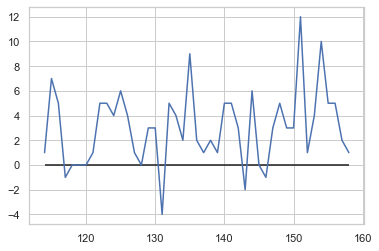

In [91]:
day_counts = [
    (ema.loc[ema.resp_time.dt.dayofyear==day,
            'happy'].sum() -
     ema.loc[ema.resp_time.dt.dayofyear==day,
            'sad'].sum()
    )
    for day
    in days
]

lplot = sns.lineplot(
    x=days,
    y=day_counts
)
plt.hlines(0, min(days), max(days))

So there are only a few outlier days where the balance is more sad than happy, but there do seem to be statistically significant trends in the data. Now let's follow the same methodology for days of the week and hours of the day.

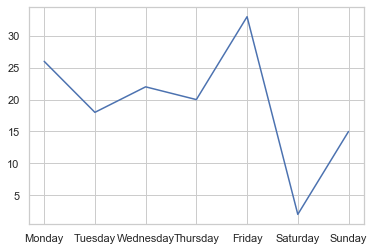

In [92]:
weekday_counts = [
    (ema.loc[ema.resp_time.dt.weekday==wkd,
            'happy'].sum() -
     ema.loc[ema.resp_time.dt.weekday==wkd,
            'sad'].sum()
    )
    for wkd
    in wkds
]

lplot = sns.lineplot(
    x=wkds,
    y=weekday_counts
)
lplot.set_xticklabels(
    ['o', 'Monday', 'Tuesday', 'Wednesday',
     'Thursday', 'Friday',
     'Saturday', 'Sunday']
)
plt.show()

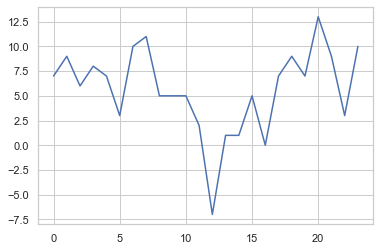

In [93]:
hour_counts = [
    (ema.loc[ema.resp_time.dt.hour==hr,
            'happy'].sum() -
     ema.loc[ema.resp_time.dt.hour==hr,
            'sad'].sum()
    )
    for hr
    in hrs
]

lplot = sns.lineplot(
    x=hrs,
    y=hour_counts
)
plt.show()

In [96]:
ema_day = pd.DataFrame(
    {'day': days,
     'net': day_counts}
)
ema_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 2 columns):
day    45 non-null int64
net    45 non-null float64
dtypes: float64(1), int64(1)
memory usage: 848.0 bytes


45

In [102]:
ema['datetime'] = pd.to_datetime(ema.resp_time)
max(ema.datetime.dt.dayofyear) - min(ema.datetime.dt.dayofyear)

108

# Adding features from other files

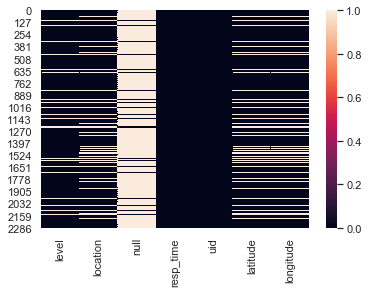

In [43]:
path = '/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/EMA/response/Stress/stress_ema.zip'

stress_zipfile = ZipFile(path)

# Extract all file names from zip_file with a list comprhension
# and if-filtering using .startswith() and .endswith()
stress_filenames = [
    text_file.filename
    for text_file
    in stress_zipfile.infolist()
    if (text_file.filename.endswith('.json') &
        ~text_file.filename.startswith('__')
       )
]

stress = concat_dfs(stress_zipfile, stress_filenames)

# Drop 'longitude' and 'latitude' because they will need
# to be recreated later
stress.drop(columns=['longitude', 'latitude'])

# Visualizing null values
sns.heatmap(stress.isnull())

In [44]:
df = stress[['level', 'location', 'null']].copy()

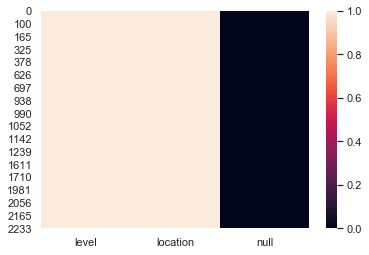

In [45]:
sns.heatmap(df[df.null.notnull()].isnull())

Let's confirm this null column works the same way in one of the original dfs and that it's not appearing because of how we're concatenating them.

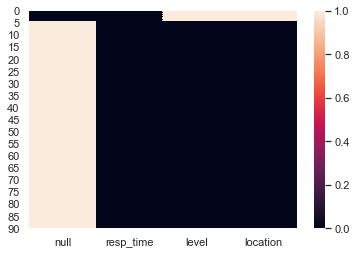

In [46]:
# Visualizing nulls from one of the dfs
sns.heatmap(pd.read_json(stress_zipfile.open(stress_filenames[0])).isnull())

Consulting one of the raw json files, it appears that in each case in which the null value isn't null, it's a value that belongs either in `level` or `resp_time`. Let's take a look at all the unique non-misisng values for `null` in the concatenated dataframe.

In [47]:
stress.null[stress.null.notnull()].unique()

array(['43.70477575,-72.28844073', '2', '43.70637091,-72.28704334', '4',
       '3', '43.70480167,-72.28843789', '43.70450324,-72.2884118', '5',
       '1', '43.70667971,-72.28698867', '43.70427927,-72.28971705',
       '43.70493499,-72.28849331', '43.70643224,-72.28718618',
       '43.70642019,-72.28709812', '43.70500256,-72.28866813',
       '43.70593753,-72.28873503', '43.70655968,-72.28710482',
       '43.70493909,-72.28852976', '43.70624514,-72.28708367',
       '43.7062285,-72.28708899', '43.70633605,-72.28701846',
       '43.70638441,-72.2870153', '43.70631925,-72.28699563',
       '43.70671572,-72.28787923', '43.70409141,-72.28921646',
       '43.70634115,-72.28705332', '43.7063577,-72.28700524',
       '43.70642256,-72.28714138', '43.70676444,-72.28705918',
       '43.70525225,-72.28868813', '43.70443648,-72.28843785',
       '43.70643452,-72.28706984', '43.70499462,-72.28868604',
       '43.70602359,-72.28875302', '43.70499885,-72.28873948',
       '43.70410494,-72.28969041',

Luckily there's a small enough number of values that we can check visually that all the values are either latlon or belong in `level`. Also, as shown below it's worth noting that in every case there's a null value in `null`, the elements in `location` and `level` are null.

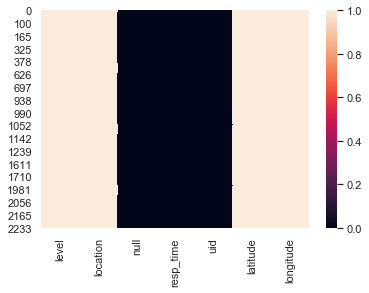

In [48]:
sns.heatmap(stress[stress.null.notnull()].isnull())

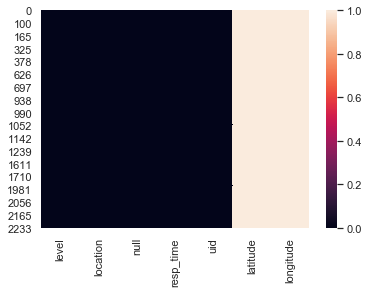

In [49]:
# Fill missing values in 'location' and ''
stress.level.fillna(
    value=stress.null,
    inplace=True
)

stress.location.fillna(
    value=stress.null,
    inplace=True
)

sns.heatmap(stress[stress.null.notnull()].isnull())

In [51]:
# Converting columns to type str so string methods work
stress = stress.astype(str)

# Using regex to change values that don't belong in column to NaN
regex = '[,]'
stress.loc[stress.level.str.contains(regex), 'level'] = np.nan
    
regex = '^\d\.?0?$'
stress.loc[stress.location.str.contains(regex), 'location'] = np.nan
    
# Returning `df.level` to float datatype (str is the correct
# datatype for `df.location`
stress.level.astype(float)

# Dropping 'df.null'
try:
    stress = stress.drop(columns=['null'])
except:
    pass

# Merging Stress and Mood Data

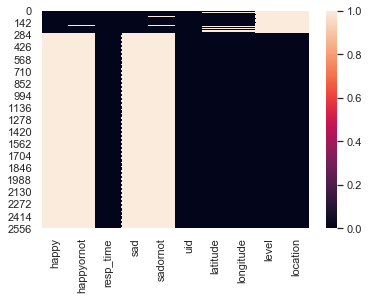

In [65]:
stress.resp_time = pd.to_datetime(stress.resp_time)
stress.uid = stress.uid.astype(float)
sns.heatmap(ema.merge(stress,
                      on=['longitude', 'latitude', 'resp_time', 'uid'],
                      how='outer'
                     ).isnull())

In [77]:


time = pd.concat(
    [stress.resp_time,
     ema.resp_time],
    axis=0
)

lplot = sns.lineplot(
    x=time,
    y=
)

SyntaxError: invalid syntax (<ipython-input-77-b9f01c70b9e0>, line 9)